# Interactome analysis

----

In this notebook we analyze the different interactomes that we inferred using the PCST algorithm. To this end, we will look use different community detection approaches to identify stable subclusters in the interactome. Those clusters will be annotated based on an enrichment analyses using different curated gene sets of pathways and functional complexes.

Additionally, we will cluster the set of specific ORF targets in the networks based on their local neighborhoods and compare the clustering with a clustering of GEX profiles obtained from the CMAP data set that describes the differential gene expression in the different overexpression constructs.

Finally, we will also compare the co-clustering of those targets in the network as well as using image embeddings.
We thereby aim to show that the proximity in the interactome partially translates to proximity in the structural as well as the functional space.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import os
import sys
import random
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from node2vec import Node2Vec
from umap import UMAP
from tqdm import tqdm
import community

sys.path.append("../../..")

seed = 1234
np.random.seed(seed)
random.seed(seed)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def plot_data(
    data,
    reduction="tsne",
    metric="euclidean",
    perplexity=30,
    normalize=False,
    labels=None,
    figsize=[12, 8],
    seed=1234,
    pcs=None,
):
    idx = data.index
    if normalize:
        data = StandardScaler().fit_transform(data)
    if pcs is not None:
        data = PCA(random_state=seed, n_components=pcs).fit_transform(data)
    if reduction == "tsne":
        embs = TSNE(
            random_state=seed,
            metric=metric,
            perplexity=perplexity,
            square_distances=True,
            n_components=2,
        ).fit_transform(data)
    elif reduction == "pca":
        embs = PCA(random_state=seed, n_components=2).fit_transform(data)
    elif reduction == "umap":
        embs = UMAP(random_state=seed).fit_transform(data)
    else:
        raise NotImplementedError()
    embs = pd.DataFrame(
        embs, columns=["{}_0".format(reduction), "{}_1".format(reduction)], index=idx
    )
    fig, ax = plt.subplots(figsize=figsize)
    if labels is None:
        ax = sns.scatterplot(
            data=embs, x="{}_0".format(reduction), y="{}_1".format(reduction)
        )
    else:
        embs["label"] = np.array(labels)
        ax = sns.scatterplot(
            data=embs,
            x="{}_0".format(reduction),
            y="{}_1".format(reduction),
            hue="label",
        )
    return fig, ax

<IPython.core.display.Javascript object>

In [3]:
def compute_node2vec_embeddings(
    graph,
    dims=64,
    walk_length=30,
    num_walks=200,
    window=10,
    batch_nodes=4,
    workers=5,
):
    nodes = list(graph.nodes())
    node2vec = Node2Vec(
        graph, dimensions=dims, walk_length=walk_length, workers=workers
    )
    model = node2vec.fit(window=window, min_count=1, batch_words=batch_nodes)
    embeddings = np.zeros([len(nodes), dims])
    for i in range(len(nodes)):
        node = nodes[i]
        embeddings[i] = model.wv[node]
    embeddings = pd.DataFrame(embeddings, index=nodes)
    return embeddings

<IPython.core.display.Javascript object>

In [4]:
def compare_dist_clustering(
    dist_df1, dist_df2, linkage1="average", linkage2="average", filter_nodes=None
):
    dist_df1_duplicates = dist_df1.index.duplicated(keep="first")
    dist_df1 = dist_df1.loc[~dist_df1_duplicates, ~dist_df1_duplicates]

    dist_df2_duplicates = dist_df2.index.duplicated(keep="first")
    dist_df2 = dist_df2.loc[~dist_df2_duplicates, ~dist_df2_duplicates]
    node_set = set(dist_df1.index).intersection(set(dist_df2.index))
    if filter_nodes is not None:
        node_set = node_set.intersection(filter_nodes)

    dist_df1 = dist_df1.loc[node_set, node_set]
    dist_df2 = dist_df2.loc[node_set, node_set]
    ari = np.zeros([len(node_set), len(node_set)])
    for i in tqdm(range(len(node_set)), desc="Compute ARI"):
        cluster_sol1 = AgglomerativeClustering(
            affinity="precomputed", n_clusters=i + 1, linkage=linkage1
        ).fit_predict(dist_df1.loc[node_set, node_set])
        for j in range(len(node_set)):
            cluster_sol2 = AgglomerativeClustering(
                affinity="precomputed", n_clusters=j + 1, linkage=linkage2
            ).fit_predict(dist_df2.loc[node_set, node_set])
            ari[i, j] = adjusted_rand_score(cluster_sol1, cluster_sol2)
    return ari

<IPython.core.display.Javascript object>

## 1. Read in data

First, we will read in the derived interactomes.

In [5]:
mis_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_mis_sol.pkl"
)
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_spearman_sol.pkl"
)

<IPython.core.display.Javascript object>

In [6]:
print(nx.info(mis_interactome))

Name: conf_hub_mis_sol
Type: Graph
Number of nodes: 1113
Number of edges: 6502
Average degree:  11.6837


<IPython.core.display.Javascript object>

In [7]:
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 754
Number of edges: 1832
Average degree:   4.8594


<IPython.core.display.Javascript object>

Next, we will read in the GEX profiles from the CMAP data set that show the response of U2OS cells in the functional domain which is closely linked to the regulatory domain.

Since the respective data is only available in the processed form of level 3 and onwards, we will for now use the final level of processing. This provides gene signatures that describe the change in the respective overexpression condition to the respective control given by the moderated z-score for the different replicates. For more information please refer to the CMAP data documentation.

Althought the signatures span over 12k genes only 978 of those were actually measured. We thus focus on those in the remainder of our analysis. The data has already been preprocessed to filter out the experiments that correspond to an overexpression of any of the gene targets also covered in our expression study.

In [8]:
cmap_data = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/gex/cmap/filtered_l5_data_u2os.csv",
    index_col=0,
)
cmap_data.head()

,CAMSAP2,PPP2R5A,CISD1,AKAP8,TMEM109,CHAC1,FOS,ORC1,AARS,MLLT11,...,SERPINE1,HLA-DMA,STK10,BLCAP,ASCC3,KDELR2,HIST2H2BE,MELK,SMARCA4,target
cid,,,,,,,,,,,,,,,,,,,,,
TA.OE005_U2OS_72H:BRDN0000464889:1,0.30090,0.31210,-0.15385,0.39090,0.53360,0.46430,1.13275,0.56370,-0.59440,0.29370,...,-0.15785,0.58080,-0.57865,0.04165,-1.00705,-0.65015,-0.10060,-0.77265,-0.22600,SMAD3
TA.OE005_U2OS_72H:BRDN0000459386:1,0.63525,0.61450,0.69230,-0.65215,-0.15565,0.45355,1.94680,-0.24965,1.02950,-1.17495,...,-0.46945,-0.18220,0.39760,2.23775,-0.46560,0.43435,0.79090,-0.32655,-2.16460,PIK3CA
TA.OE005_U2OS_72H:BRDN0000410175:1,-0.29245,0.36240,0.11330,-0.26385,0.48625,-0.78705,-0.90775,-0.34735,-0.14545,-0.58355,...,1.00105,0.10480,-0.13915,-0.02055,-0.33860,0.33100,-0.38375,5.86720,-0.62195,SGK3
TA.OE005_U2OS_72H:BRDN0000464950:1,-0.56500,1.14185,-0.28610,0.50840,0.27205,0.21970,-0.59960,0.44335,0.51885,0.23335,...,-1.20675,2.18695,-1.06025,-0.01255,0.51865,-0.43130,-0.54085,0.21715,-1.36070,TSC1
TA.OE005_U2OS_72H:BRDN0000411728:1,-0.94355,0.09785,0.19735,-0.34985,-0.55525,-0.53205,0.56505,-0.51840,0.56295,-0.68630,...,0.80700,0.55225,-0.04225,0.05315,0.21825,0.56270,-1.04495,0.97745,-0.66255,IKBKE


<IPython.core.display.Javascript object>

Finally, we will read in some more information regarding our ORF targets including their involvement in important pathways and whether or not they showed a specific structural phenotype upon overexpression.

In [9]:
spec_screen_data = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_screen_data.head()
orf_targets = set(spec_screen_data.index)
spec_targets = set(spec_screen_data.loc[spec_screen_data["selected"]].index)

<IPython.core.display.Javascript object>

---

## 2. Clustering 

Next, we will run several clustering analyses to see identify clusters in the derived interactome. Similarly, we will cluster the CMAP data to identify targets that lead to similar functional phenotypes upon overexpression. Finally, we will cluster the individual targets in the structural space defined by our computed image embeddings. We will analyze the co-clustering of those nodes to provide validation for our inferred interactome and initial evidence for the links between the different spaces: functional, regulatory and structural spaces inside cells.

### 2.1. Clustering of the CMAP data set

First, we will cluster the CMAP data set. For simplicity we will apply agglomerative clustering using the cosine similarity between the different gene signatures. The intuition for using the cosine simularity is that we are interested in finding clusters of gene targets whose OE pushes the cell into similar directions in the functional space which is approximated by the space spanned by gene signatures on the 978 landmark genes.

#### 2.1.a. TSNE visualization of the data.

Before we proceed we will however visualize the data using a TSNE plot where we use the cosine distance to build the nearest neighbor graph.

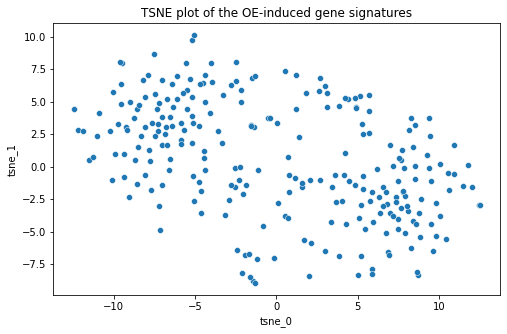

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plot_data(
    cmap_data.iloc[:, :-1],
    metric="cosine",
    perplexity=30,
    figsize=[8, 5],
    normalize=True,
    reduction="tsne",
)
ax.set_title("TSNE plot of the OE-induced gene signatures")
plt.show()

The plot shows that there is quite some structure in the gene signatures with at least two clusters becoming apparent.

#### 2.1.b. Cosine simularity clustering.

Next, we will perform agglomerative clustering of the data based on their cosine similarities. However, we will focus only on that part of the data that describes OE epression for which we also have imaging data available.

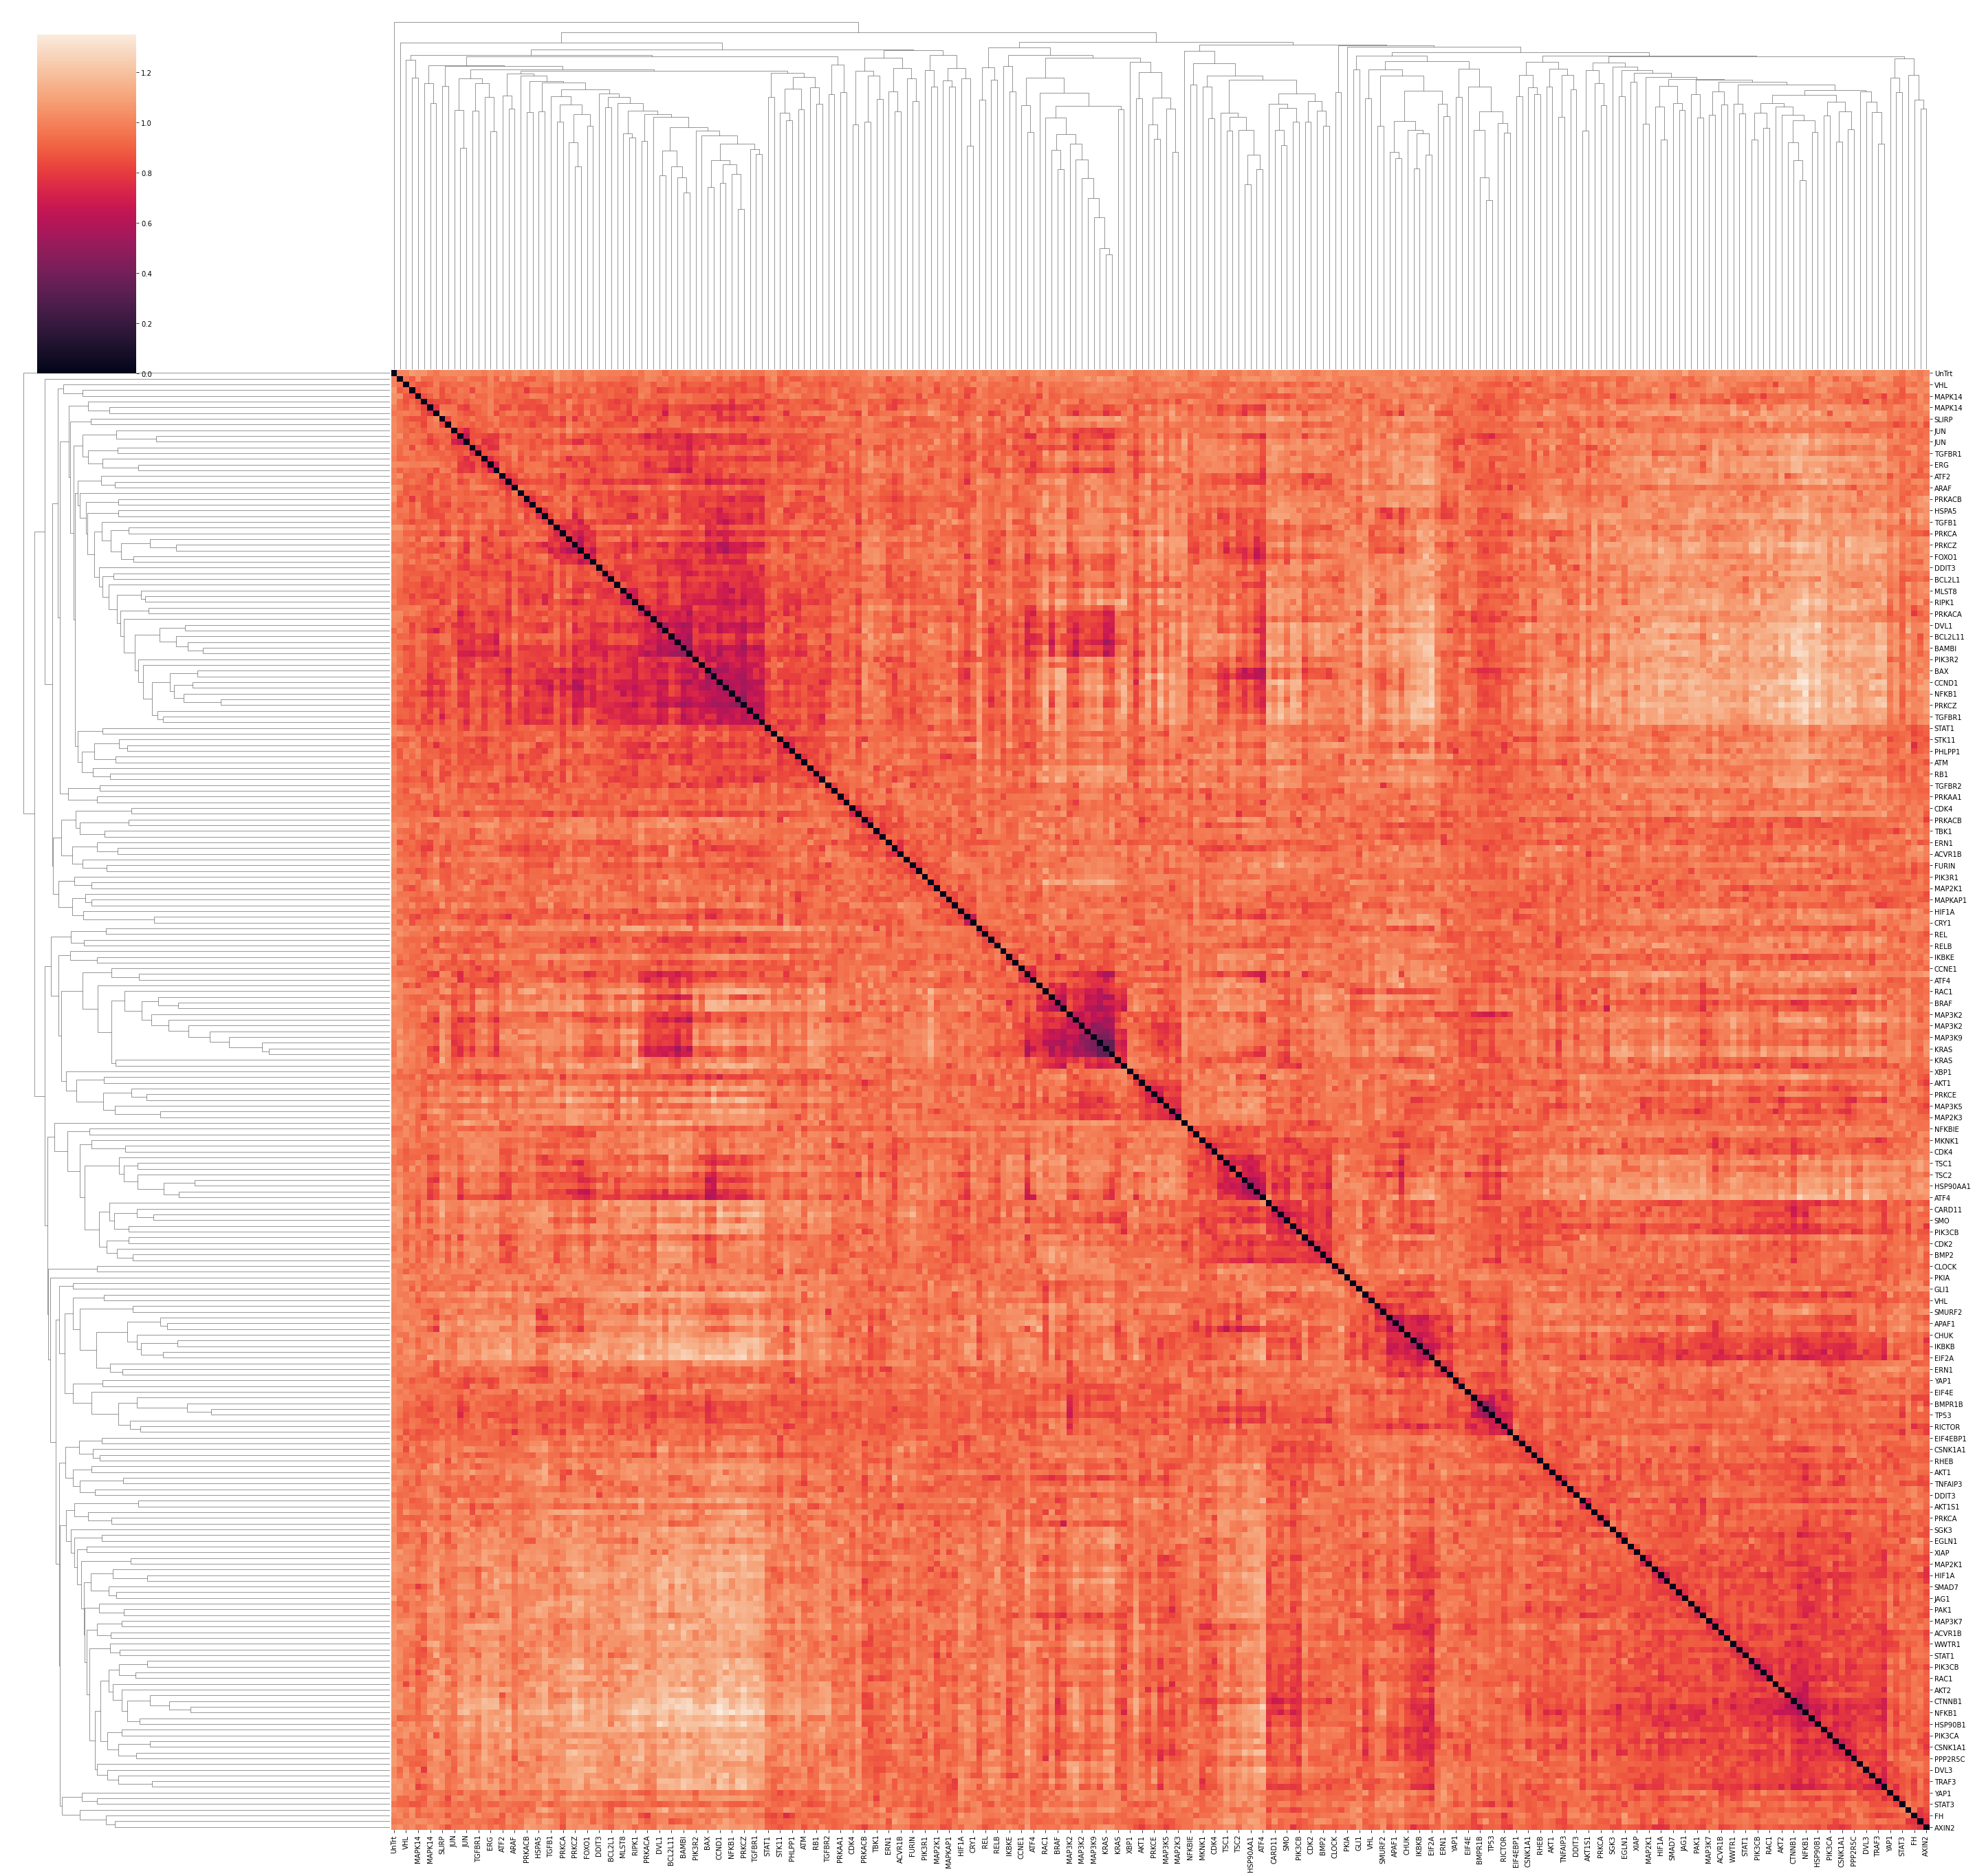

<IPython.core.display.Javascript object>

In [139]:
cmap_cosine_dist = pd.DataFrame(
    squareform(pdist(cmap_data.iloc[:, :-1], metric="cosine")),
    columns=list(cmap_data.iloc[:, -1]),
    index=list(cmap_data.iloc[:, -1]),
)
linkage = hc.linkage(sp.distance.squareform(cmap_cosine_dist), method="average")
ax = sns.clustermap(
    cmap_cosine_dist, row_linkage=linkage, col_linkage=linkage, figsize=[40, 38]
)

The plotted heatmap shows the cosine distance between each individual gene signature and a hierarchical clustering of the respective using the euclidean distance and Ward linkage.

Interestingly, we see that e.g. OE condition that target different alleles of FOXO1 cluster together as expected. The clustering will be analyzed further later in comparison to the clustering obtained in the regulatory and structural space.

---

### 2.2. Clustering the interactome

To identify regulatory modules in the derived interactomes we aim to cluster the targets in the networks based on the similarity of their local neighborhoods. To this end, we propose to embed the networks in a lower-dimensional space using node2vec and cluster those embeddings.

#### 2.2.a. MIscore-based interactome

##### Computing the interactome embedding

In [12]:
dims = 64
walk_length = 30
n_walks = 300
n_workers = 5
window = 10
batch_nodes = 4

<IPython.core.display.Javascript object>

In [13]:
mis_node2vec_embs = compute_node2vec_embeddings(
    mis_interactome,
    dims=dims,
    walk_length=walk_length,
    num_walks=n_walks,
    window=window,
    batch_nodes=batch_nodes,
    workers=n_workers,
)

Computing transition probabilities:   0%|          | 0/1113 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [14]:
mis_node2vec_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
PIK3C3,0.392515,0.248647,0.749829,-0.245808,0.685709,0.161399,0.347534,-0.625283,-0.566568,-0.238297,...,-0.497217,-1.127437,-0.488078,0.108307,0.244323,0.478102,-0.501085,-0.050134,0.430041,-0.036323
UBTF,-0.332572,0.559905,-0.136385,0.050116,0.037836,-0.555220,0.013583,0.012524,0.165448,0.173704,...,0.244446,-0.275747,0.225967,-0.150107,-0.188651,0.289919,-0.065123,-0.349579,-0.072449,-0.366778
AURKB,-0.593376,-0.213214,0.082684,-0.595083,0.364357,-0.251702,0.339012,0.325569,-0.022175,0.090300,...,-0.449578,-0.006051,0.410912,-0.217463,-0.163674,0.308379,-0.416859,-0.001253,0.144689,0.226806
DUSP1,0.003506,0.149993,-0.091514,0.459563,0.721669,0.352503,-0.031951,-0.182630,-0.660967,-0.204738,...,-0.012464,-0.415147,0.145400,-0.233814,-0.329841,0.467758,0.070499,-0.456367,0.404560,0.151385
SMARCC2,-0.057385,0.047286,-0.198086,-0.175867,0.137556,-0.132129,-0.119886,-0.523476,-0.277849,-0.259374,...,-1.136975,0.265264,0.751311,0.439287,-0.794628,-0.024712,-0.132915,-0.388651,-0.128776,0.425618


<IPython.core.display.Javascript object>

##### Visualization of the node embedding

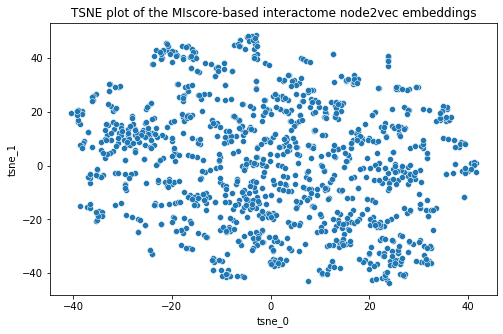

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plot_data(
    mis_node2vec_embs,
    metric="euclidean",
    perplexity=30,
    figsize=[8, 5],
    normalize=True,
    reduction="tsne",
)
ax.set_title("TSNE plot of the MIscore-based interactome node2vec embeddings")
plt.show()

The above TSNE plot shows quite some structure. To better understand which ORF targets cluster together, we will cluster the distance matrix between any of the covered ORF targets.

##### Clustering of the ORF target node2vec embeddings

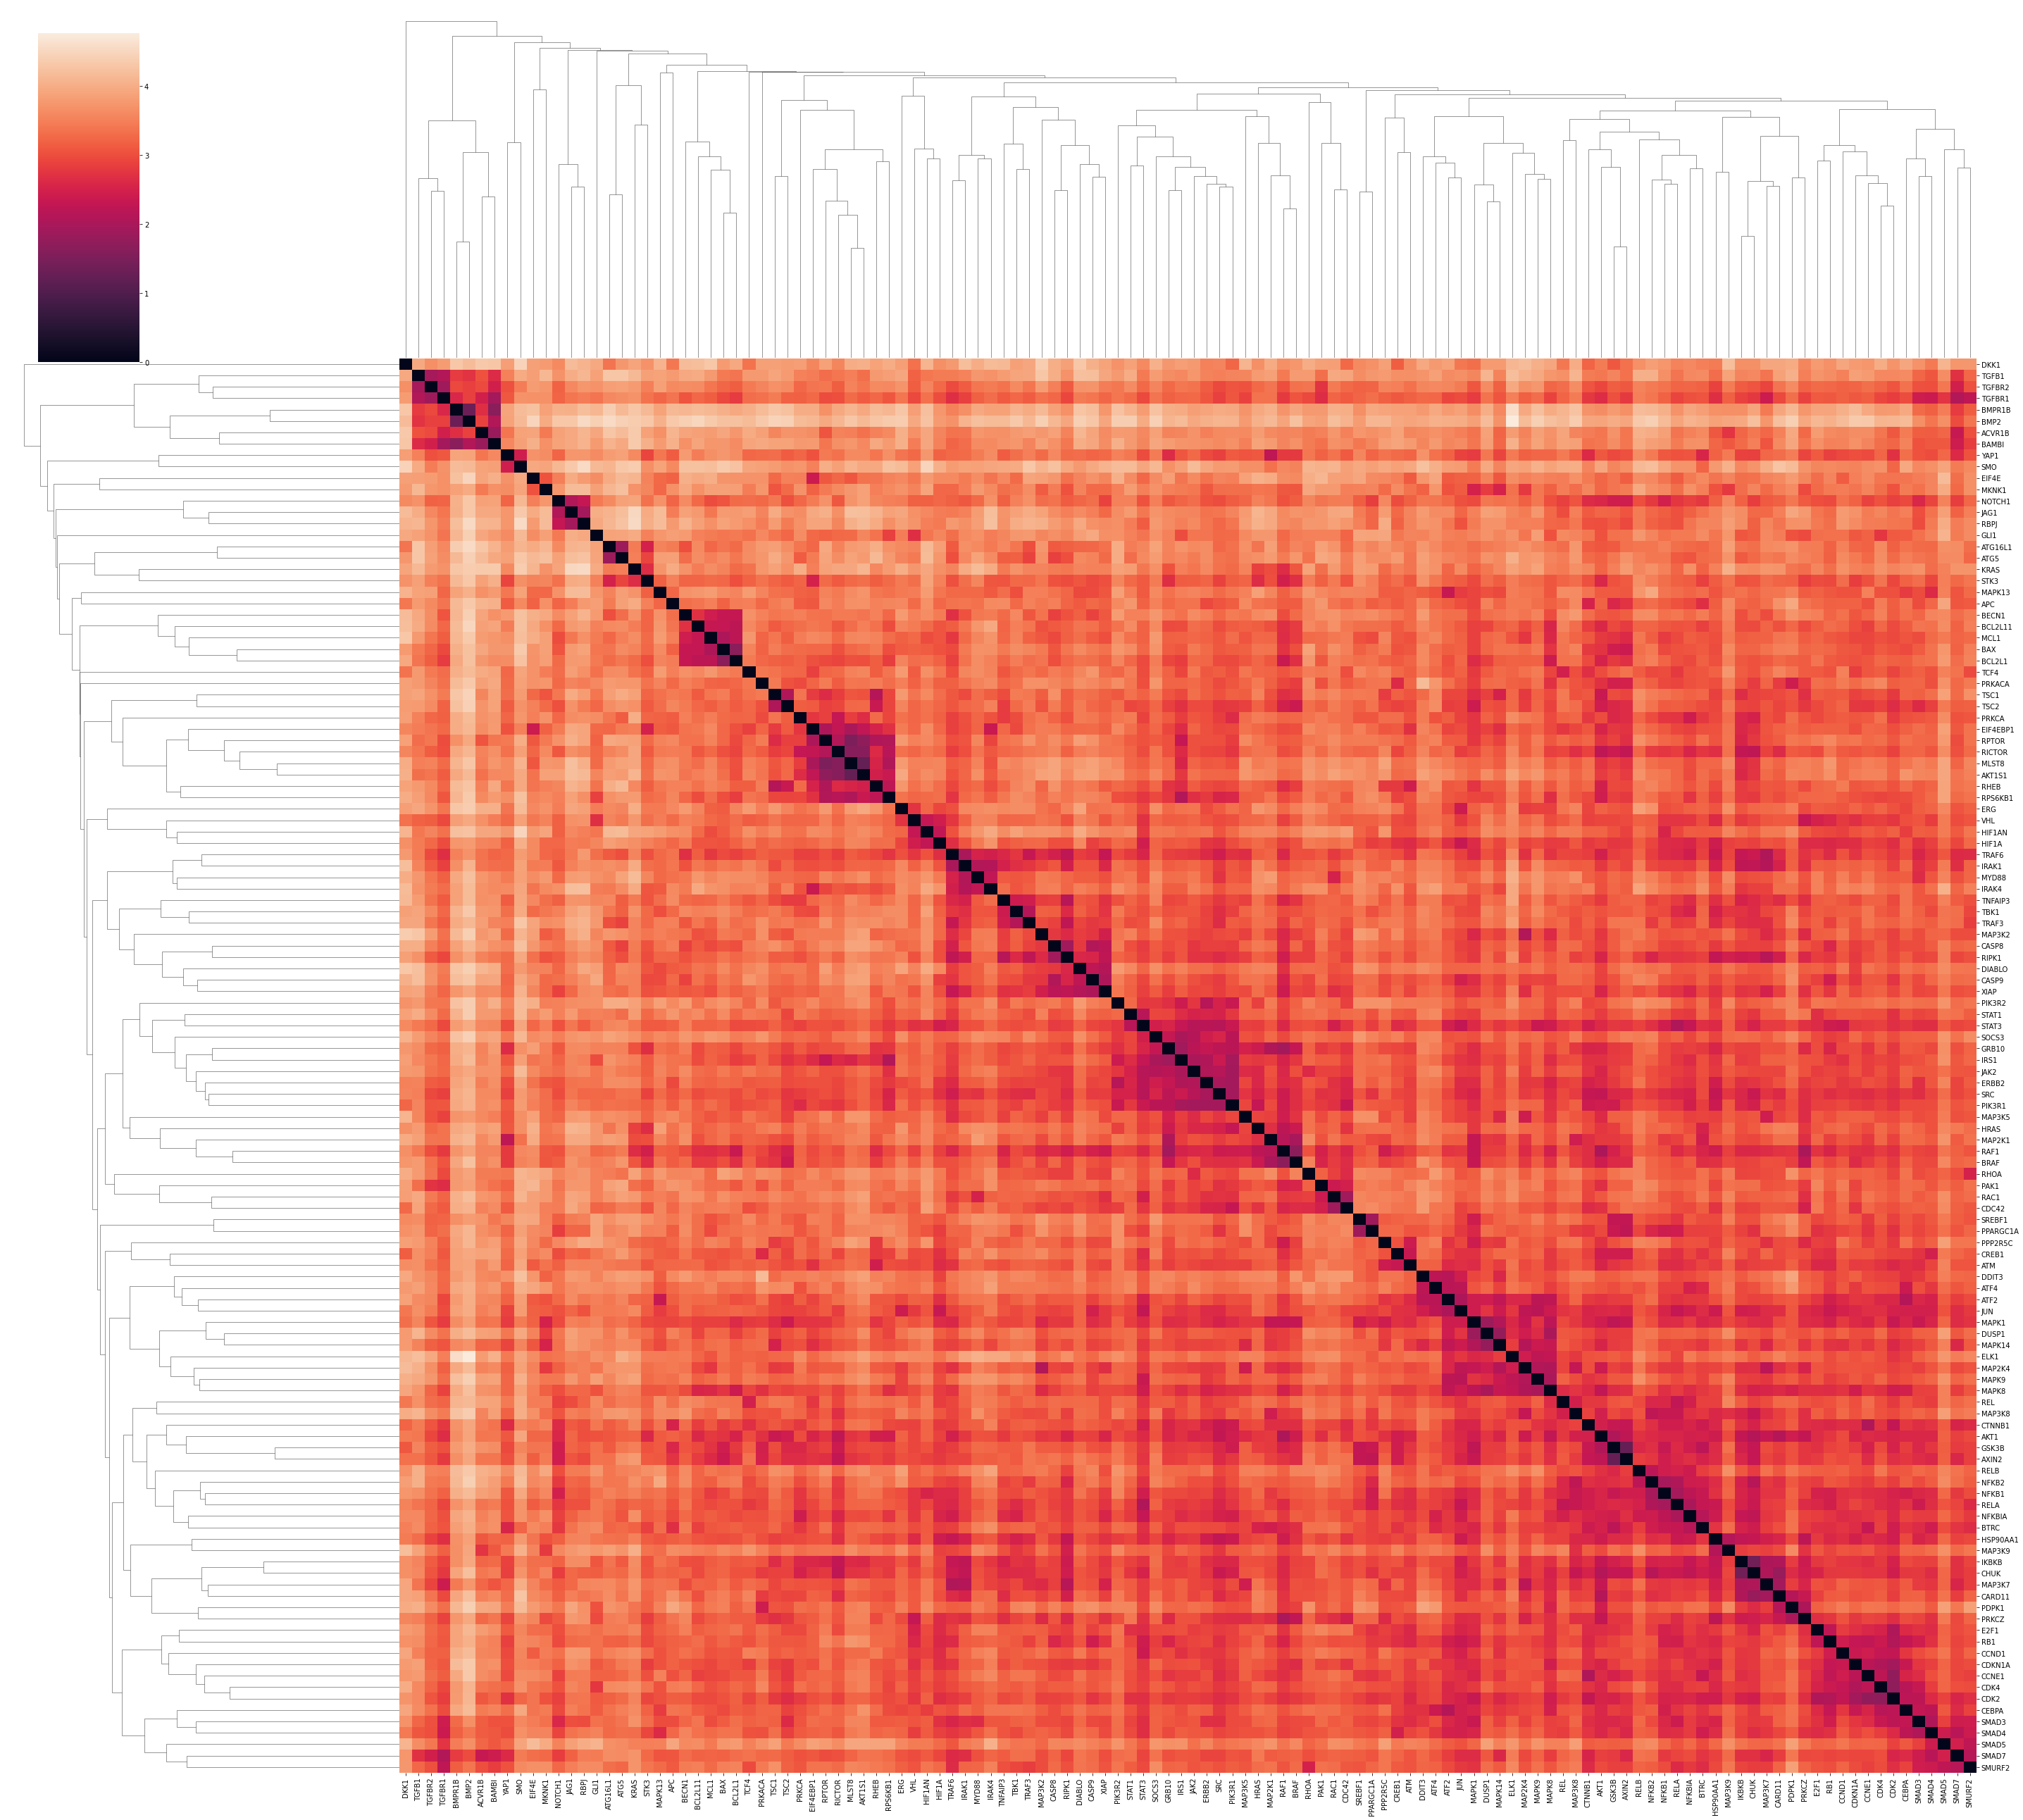

<IPython.core.display.Javascript object>

In [16]:
mis_target_n2v_embs = mis_node2vec_embs.loc[
    orf_targets.intersection(set(mis_node2vec_embs.index))
]
mis_target_n2v_embs_dist = squareform(pdist(mis_target_n2v_embs, metric="euclidean"))
mis_target_n2v_embs_dist = pd.DataFrame(
    mis_target_n2v_embs_dist,
    columns=list(mis_target_n2v_embs.index),
    index=list(mis_target_n2v_embs.index),
)
linkage = hc.linkage(sp.distance.squareform(mis_target_n2v_embs_dist), method="average")
ax = sns.clustermap(
    mis_target_n2v_embs_dist, row_linkage=linkage, col_linkage=linkage, figsize=[40, 36]
)

We see that the proximity in the embedding space well captures the proximity in the input interactome as expected. For instance we see the caspases or genes involved in the TGF $\beta$ signaling complex to group together.

---

#### 2.2.b. Clustering the Spearman-based interactome

In [17]:
spearman_node2vec_embs = compute_node2vec_embeddings(
    spearman_interactome,
    dims=dims,
    walk_length=walk_length,
    num_walks=n_walks,
    window=window,
    batch_nodes=batch_nodes,
    workers=n_workers,
)

Computing transition probabilities:   0%|          | 0/754 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [18]:
spearman_node2vec_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
HDAC11,0.390867,0.048127,0.087645,0.997122,0.181230,-0.148165,0.039055,-0.539327,0.081841,0.119309,...,-0.342495,-0.038705,-0.220136,-0.717117,0.024243,-0.017888,-0.469697,0.050541,-0.017306,-0.362061
NCOA3,0.023014,0.197313,0.413004,0.542954,0.276853,-0.664546,0.161126,-0.048762,-0.618278,-0.196809,...,0.207117,-0.117195,-0.228208,-0.452639,-0.008139,-0.290660,-0.181397,0.360740,0.029975,0.287819
AURKB,0.666779,-0.266749,0.338214,0.634067,0.580380,-0.283204,0.097877,0.241382,-0.280254,0.012351,...,0.320166,-0.029530,-0.033200,-0.287401,-0.692350,0.220458,-0.218257,0.523559,-0.542693,0.277950
DUSP1,-0.131876,0.057848,0.168150,0.581939,0.487385,-0.458814,0.094097,-0.253719,-0.207522,0.296650,...,0.148452,-0.393760,-0.358655,-0.106968,0.154731,0.038643,-0.528837,0.326407,0.095760,0.064778
PARD6G,-0.126791,0.014102,-0.122877,0.127808,-0.263235,-0.556747,0.510073,0.322319,-0.596011,0.267415,...,0.343435,-0.233276,0.258235,-0.650050,-0.176375,-0.284364,0.217648,-0.481337,-0.436170,-0.263863


<IPython.core.display.Javascript object>

##### Visualization of the node embedding

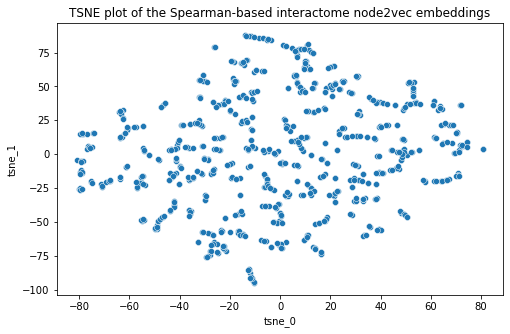

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plot_data(
    spearman_node2vec_embs,
    metric="euclidean",
    perplexity=5,
    figsize=[8, 5],
    normalize=True,
    reduction="tsne",
)
ax.set_title("TSNE plot of the Spearman-based interactome node2vec embeddings")
plt.show()

The above TSNE plot shows a little bit less structure as before for the MIscore-based interactome. Importantly, the interactome derived based on the Spearman correlation also spans less of the ORF targets.

##### Clustering of the ORF target node2vec embeddings

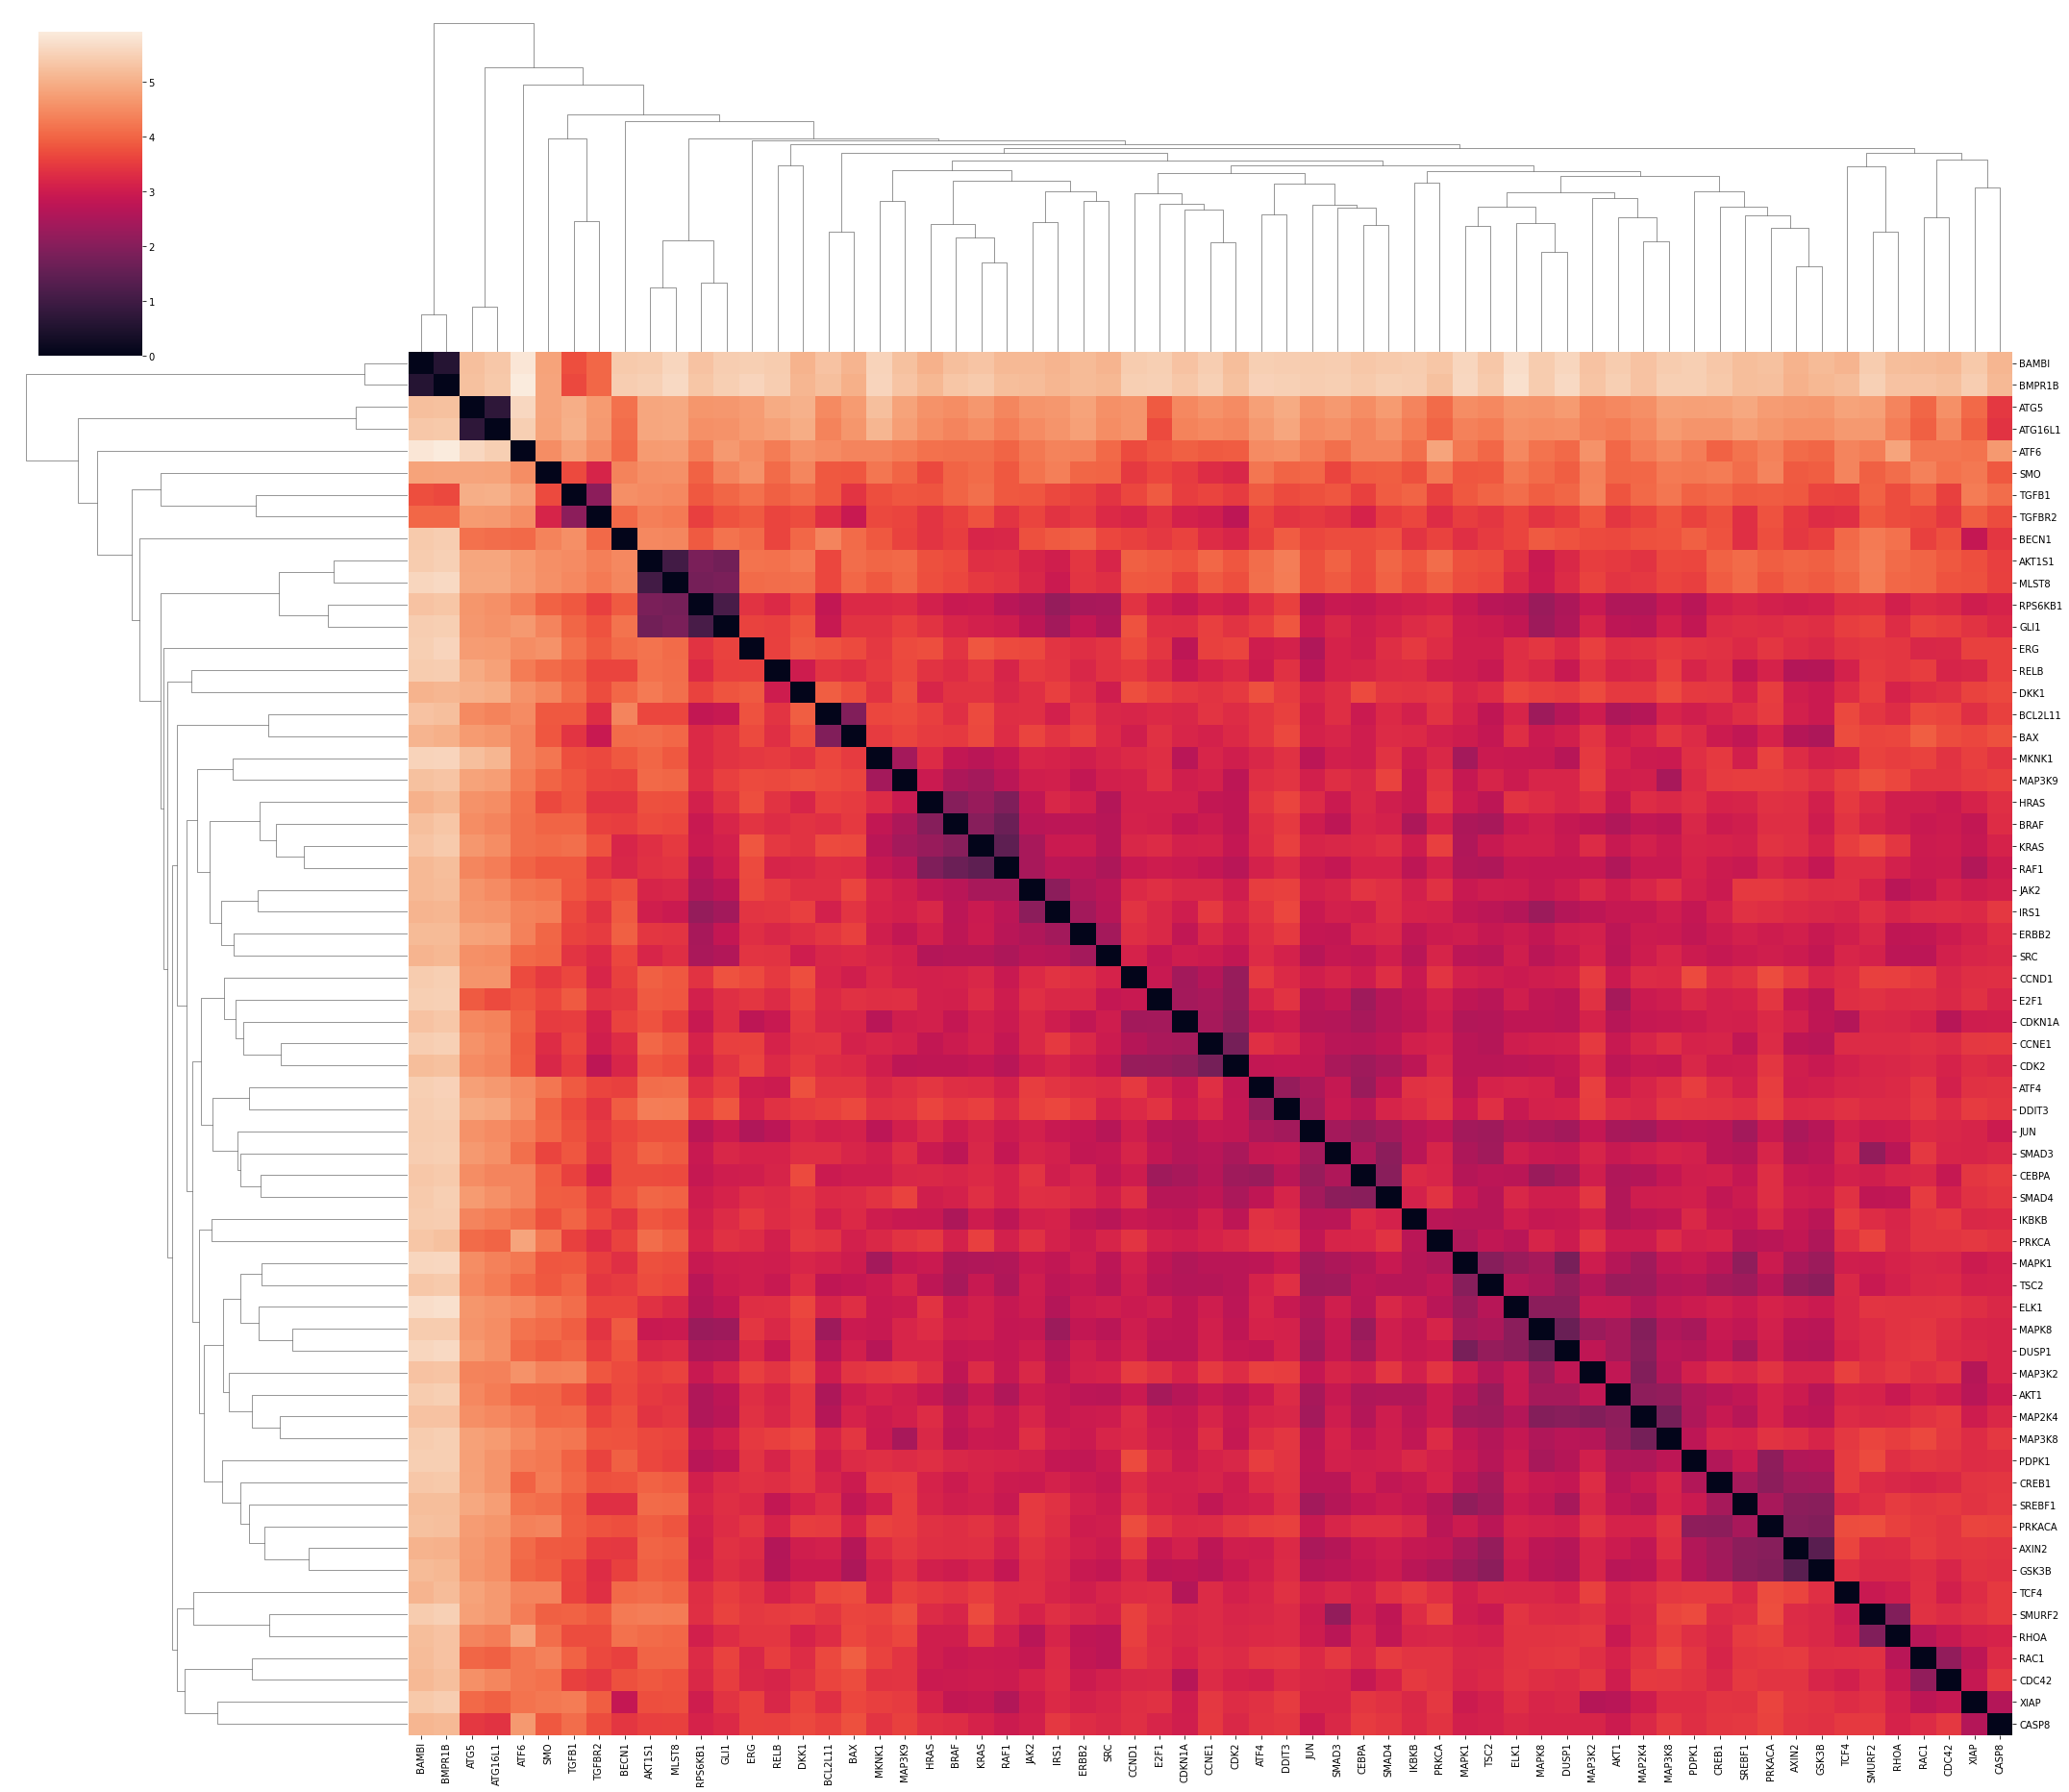

<IPython.core.display.Javascript object>

In [20]:
spearman_target_n2v_embs = spearman_node2vec_embs.loc[
    orf_targets.intersection(set(spearman_node2vec_embs.index))
]
spearman_target_n2v_embs_dist = squareform(
    pdist(spearman_target_n2v_embs, metric="euclidean")
)
spearman_target_n2v_embs_dist = pd.DataFrame(
    spearman_target_n2v_embs_dist,
    columns=list(spearman_target_n2v_embs.index),
    index=list(spearman_target_n2v_embs.index),
)
linkage = hc.linkage(
    sp.distance.squareform(spearman_target_n2v_embs_dist), method="average"
)
ax = sns.clustermap(
    spearman_target_n2v_embs_dist,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=[30, 26],
)

However, the functional grouping seems to remain reserved. This is not surprising as the inferred interactomes describe a subset of the human PPI which captures known functional modules and regulatory relationships.

---

### 2.3. Comparison of the clustering

To better understand how well the proximity that is captured in the interactome of any two nodes corresponds to the proximity in the space spanned by the OE gene signatures, we will perform two analyses:
1. We will assess the co-clustering using the adjusted RandIndex for different choices of the number of clusters in the hierarchical clustering that we obtained previously.
2. We will identify communities in the interactomes and assess the distribution of the cosine simularities of those targets within the same community against those outside of the same community.

#### 2.3.a. Evaluating the agglomerative cluster solutions

Compute ARI: 100%|██████████| 56/56 [00:05<00:00,  9.36it/s]


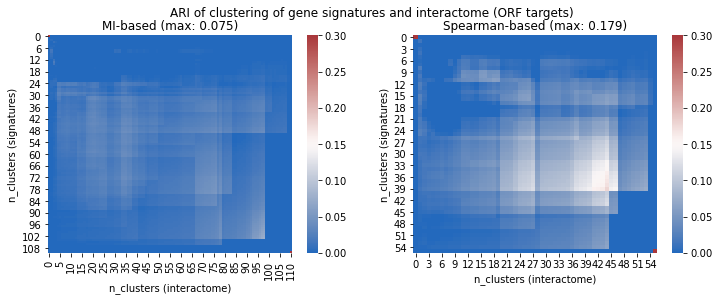

<IPython.core.display.Javascript object>

In [140]:
mis_ari = compare_dist_clustering(
    mis_target_n2v_embs_dist,
    cmap_cosine_dist,
    linkage1="average",
    linkage2="average",
    filter_nodes=orf_targets,
)
spearman_ari = compare_dist_clustering(
    spearman_target_n2v_embs_dist,
    cmap_cosine_dist,
    linkage1="average",
    linkage2="average",
    filter_nodes=orf_targets,
)

fig, ax = plt.subplots(ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.heatmap(mis_ari, cmap="vlag", vmin=0, vmax=0.3, ax=ax[0])
ax[0].set_title("MI-based (max: {})".format(np.round(mis_ari[mis_ari < 1].max(), 3)))
ax[0].set_xlabel("n_clusters (interactome)")
ax[0].set_ylabel("n_clusters (signatures)")
ax[1] = sns.heatmap(spearman_ari, cmap="vlag", vmin=0, vmax=0.3, ax=ax[1])
ax[1].set_title(
    "Spearman-based (max: {})".format(np.round(spearman_ari[spearman_ari < 1].max(), 3))
)
ax[1].set_xlabel("n_clusters (interactome)")
ax[1].set_ylabel("n_clusters (signatures)")
fig.suptitle("ARI of clustering of gene signatures and interactome (ORF targets)")
plt.show()

We see that the agreement of the clustering measured by the ARI is relatively small using the euclidean distances of the node embeddings obtained via node2vec and the cosine distances of the gene signatures of the 978 landmark genes. For the MIscore-based interactome that spans 111 ORF targets the maximum ARI is similar to chance which is equal to 0.075. The interactome that we obtained using the Spearman-based edge weights only spans 56 ORF targets however, we see that the agreement of the co-clustering for 2 clusters for the gene signatures and 8 clusters in the interactome is substantially larger and equal to 0.179.

Compute ARI: 100%|██████████| 37/37 [00:02<00:00, 15.56it/s]


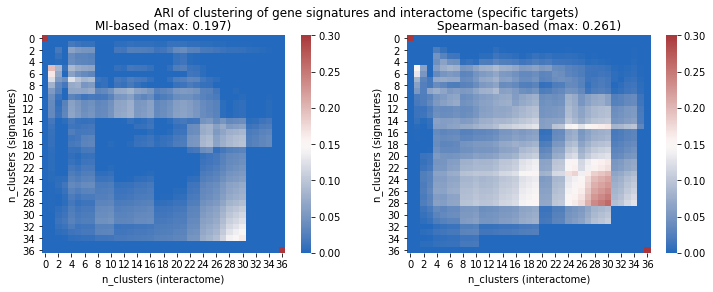

<IPython.core.display.Javascript object>

In [141]:
mis_ari = compare_dist_clustering(
    mis_target_n2v_embs_dist,
    cmap_cosine_dist,
    linkage1="average",
    linkage2="average",
    filter_nodes=spec_targets,
)
spearman_ari = compare_dist_clustering(
    spearman_target_n2v_embs_dist,
    cmap_cosine_dist,
    linkage1="average",
    linkage2="average",
    filter_nodes=spec_targets,
)

fig, ax = plt.subplots(ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.heatmap(mis_ari, cmap="vlag", vmin=0, vmax=0.3, ax=ax[0])
ax[0].set_title("MI-based (max: {})".format(np.round(mis_ari[mis_ari < 1].max(), 3)))
ax[0].set_xlabel("n_clusters (interactome)")
ax[0].set_ylabel("n_clusters (signatures)")
ax[1] = sns.heatmap(spearman_ari, cmap="vlag", vmin=0, vmax=0.3, ax=ax[1])
ax[1].set_title(
    "Spearman-based (max: {})".format(np.round(spearman_ari[spearman_ari < 1].max(), 3))
)
ax[1].set_xlabel("n_clusters (interactome)")
ax[1].set_ylabel("n_clusters (signatures)")
fig.suptitle("ARI of clustering of gene signatures and interactome (specific targets)")
plt.show()

Interestingly, those scores slighlty increase (0.162 and 0.266) when we address the co-clustering of only those 37 ORF targets that showed a specific response in our imaging screen and for which we have the corresponding gene signatures available.